# Example Fine-Tuning Code of ImageNet DNNs

In [1]:
# !pip install -r requirements.txt --index-url https://download.pytorch.org/whl/cu113
import warnings; warnings.filterwarnings("ignore")
import os, sys; sys.path.insert(0, os.getcwd())
import torch
import torchvision

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float64

### Load the ResNet152 pytorch model from torchvision

In [2]:
model = torchvision.models.resnet152(pretrained=True).to(device,dtype).eval()

### Construct the repair set from the ImageNet-NAE (Natural Adversarial Example) dataset.

misclassified: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Expected labels: [0, 0, 0, 0, 0]
Misclasssified as: [487, 35, 978, 489, 107]


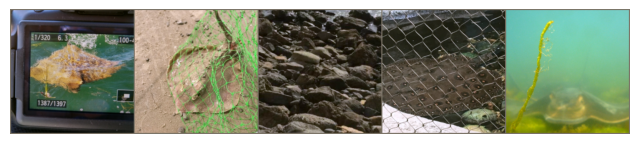

In [3]:
# !make data/imagenet-a
from experiments import imagenet

# Find `num_points` misclassified images from ImageNet-NAE as the repair set.
num_points = 5
repair_dataset = imagenet.datasets.ImageNet_A('./data/imagenet-a')\
        .to(dtype=dtype, device=device)\
        .misclassified(model, num=num_points, seed=None)

# Dataloader.
batch_size = num_points
repair_dataloader = repair_dataset.dataloader(batch_size=batch_size)

# Check images from the repair set.
images, labels = repair_dataset.load()
misclassified_labels = model(images).argmax(-1).cpu()
print(f"Expected labels: {labels.flatten().cpu().tolist()}")
print(f"Misclasssified as: {misclassified_labels.flatten().cpu().tolist()}")
imagenet.datasets.imshow(images, figsize=(8,5))

### Fine-tune this ResNet152 model

In [4]:
# Create an SGD optimizer with model's parameters.
optimizer = torch.optim.SGD(model.parameters(), 1e-4)

# Specify a subset of parameters to fine-tune to avoid drastic drawdown.
model.requires_grad_(False)
model.layer4[-1].conv3.requires_grad_()
model.fc.requires_grad_()

# Create the criterion for ImageNet.
criterion = torch.nn.CrossEntropyLoss().to(device)

# The fine-tuning loop.
for epoch in range(10):
    for batch_images, batch_labels in repair_dataloader:
        
        # Toggle the training mode.
        model.train()
        
        batch_images = batch_images.to(device,dtype)
        batch_labels = batch_labels.to(device).long().squeeze(-1)
        
        # Forward pass and compute the loss.
        outputs = model(batch_images)
        loss = criterion(outputs, batch_labels)

        # Zero gradients, perform a backward pass, and update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Check efficacy
        model.eval()
        efficacy = repair_dataset.accuracy(model)
        print(f"Epoch {epoch} efficacy: {efficacy:.2%}")
        if efficacy == 1.:
            print("repaired!")
            break

Evaluating accuracy...:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0 efficacy: 0.00%


Epoch 1 efficacy: 0.00%


Epoch 2 efficacy: 0.00%


Epoch 3 efficacy: 0.00%


Epoch 4 efficacy: 0.00%


Epoch 5 efficacy: 0.00%


Epoch 6 efficacy: 0.00%


Epoch 7 efficacy: 0.00%


Epoch 8 efficacy: 0.00%


Epoch 9 efficacy: 0.00%


### Evaluate accuracy of the fine-tuned model
Although the model is not repaired at all, the drawdown is already very high after 10 epochs.

In [6]:
og_acc1 = 0.78312
og_acc5 = 0.94046
with torch.no_grad():
    editable_model = model.to(dtype=torch.float32)
    testset = imagenet.datasets.ImageNet(split='val').to(dtype=torch.float32, device=device)
    acc1, acc5 = testset.accuracy(editable_model, topk=(1, 5), batch_size=100)
print(f"top-1 accuracy: {og_acc1:.3%} -> {acc1:.3%} ({acc1 - og_acc1:.3%})")
print(f"top-5 accuracy: {og_acc5:.3%} -> {acc5:.3%} ({acc5 - og_acc5:.3%})")

Evaluating accuracy...:   0%|          | 0/500 [00:00<?, ?it/s]

top-1 accuracy: 78.312% -> 73.234% (-5.078%)
top-5 accuracy: 94.046% -> 91.506% (-2.540%)
